In [89]:
import skimage.data as skid
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import ndimage
import imageio.v2 as imgio
import skimage.filters as skifltr
from skimage import morphology
from sklearn.neighbors import KNeighborsClassifier
import os
from random import randint

In [5]:
def error_matrix(image, hand, mask):
    result_img = np.zeros((image.shape[0],image.shape[1],3))
    result_mat = np.zeros((2,2))
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if mask[x][y] == 0:
                continue
                
            #predicted positive <=> actual positive    
            if image[x][y] != 0 and hand[x][y] != 0:
                result_mat[0][0] += 1
                result_img[x][y] = list([255,255,255])
                continue
            
            #predicted negative <=> actual negative    
            if image[x][y] == 0 and hand[x][y] == 0:
                result_mat[1][1] += 1
                continue
                
            #predicted positive <=> actual negative    
            if image[x][y] != 0 and hand[x][y] == 0:
                result_mat[0][1] += 1
                result_img[x][y] = list([255,0,0])
                continue
            
            #predicted negative <=> actual positive    
            if image[x][y] == 0 and hand[x][y] != 0:
                result_mat[1][0] += 1
                result_img[x][y] = list([0,0,255])
                continue
    TP = result_mat[0][0]
    FP = result_mat[0][1]
    TN = result_mat[1][1]
    FN = result_mat[1][0]
    effect = dict()
    effect['accuracy'] = round((TP+TN)/(TP+TN+FP+FN) * 100, 2)
    effect['sensitivity'] = round(TP/(TP+FN) * 100, 2)
    effect['specificity'] = round(TN/(FP+TN) * 100, 2)
    effect['precision'] = round(TP/(TP+FP) * 100, 2)

    return result_img, result_mat, effect
                

In [32]:
def show_img(image, gray=True):
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    if(gray):
        plt.imshow(image, cmap='gray');
    else:
        plt.imshow(image);
    return

In [33]:
def get_green_channel(image):
    _, green_channel, _ = cv2.split(image)
    return green_channel

In [309]:
def get_eye_mask(image, threshold):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask = np.zeros((image.shape[0], image.shape[1]))
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):

            if image[row][col] <= threshold: 
                mask[row][col] = 0
            else: 
                mask[row][col] = 255
    
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE,np.ones((3,3)))

In [35]:
def extract_eye(image, mask):
    eye = np.zeros((image.shape[0], image.shape[1]))
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if mask[row][col] == 255:
                eye[row][col] = image[row][col]
            else:
                eye[row][col] = 0
    return eye

In [375]:
def remove_contours(image, mask, width):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cnt = cv2.drawContours(zero, contours, -1, (255,255,255), width)
    copy = image.copy()
    for x in range(cnt.shape[0]):
        for y in range(cnt.shape[1]):
            if cnt[x][y] != 0:
                copy[x][y] = 0
    return copy

# 1. Morphological transforms

Enter the name of the file you want to scan:
im0077


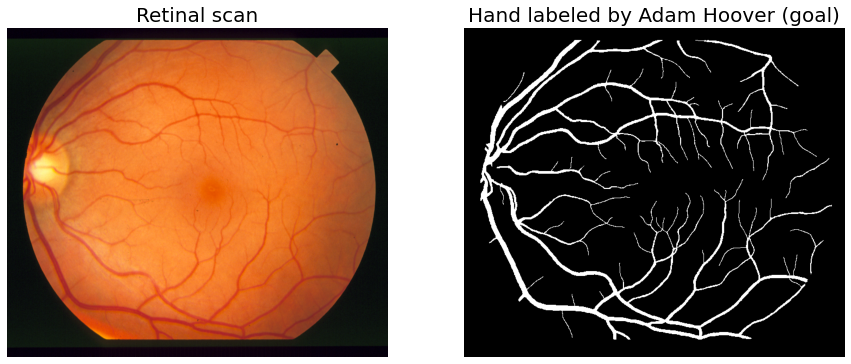

In [192]:
print('Enter the name of the file you want to scan:')
filepath = input()
try:
    img = imgio.imread('images/'+filepath+'.ppm')
    hand_labeled = imgio.imread('hand/'+filepath+'.ah.ppm')
    _, ax = plt.subplots(1,2,figsize=(15, 30))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title('Retinal scan',fontsize=20)
    ax[0].imshow(img);
    ax[1].set_title('Hand labeled by Adam Hoover (goal)',fontsize=20)
    ax[1].imshow(hand_labeled, cmap='gray');
    
except FileNotFoundError:
    print('No such file found!')

## Extracting green channel

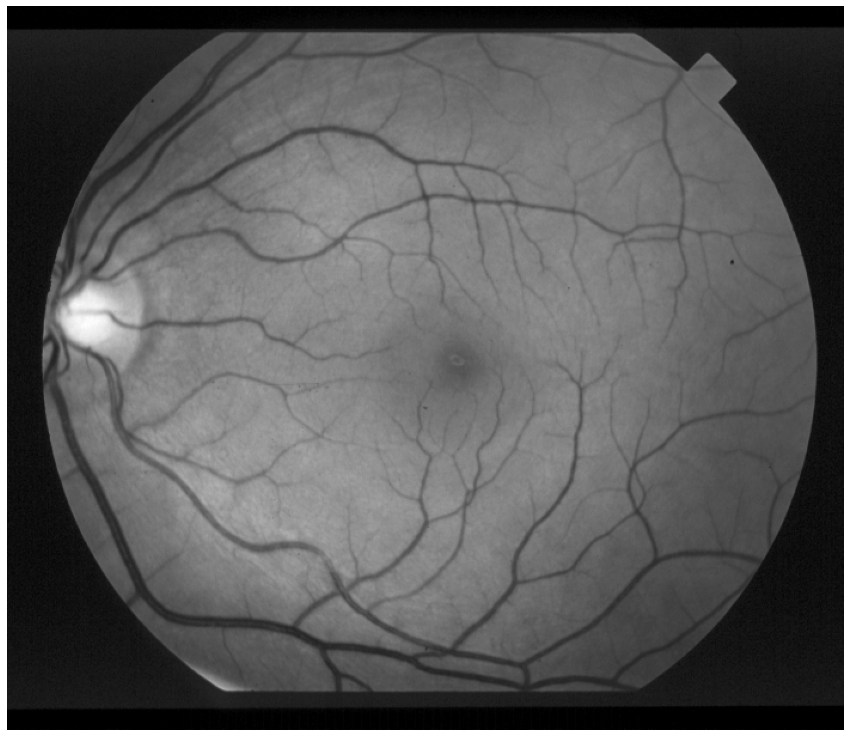

In [193]:
img_green = get_green_channel(img)
show_img(img_green)

## Getting a mask of the eye

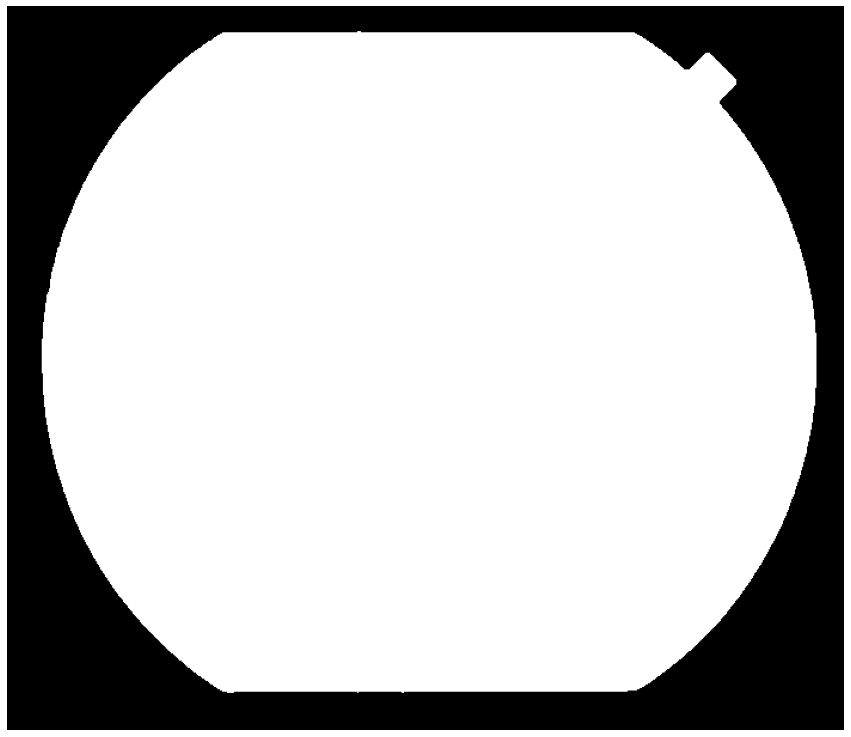

In [310]:
img_mask = get_eye_mask(img, 50)
show_img(img_mask)

## Extracting the eye from green channel using the mask

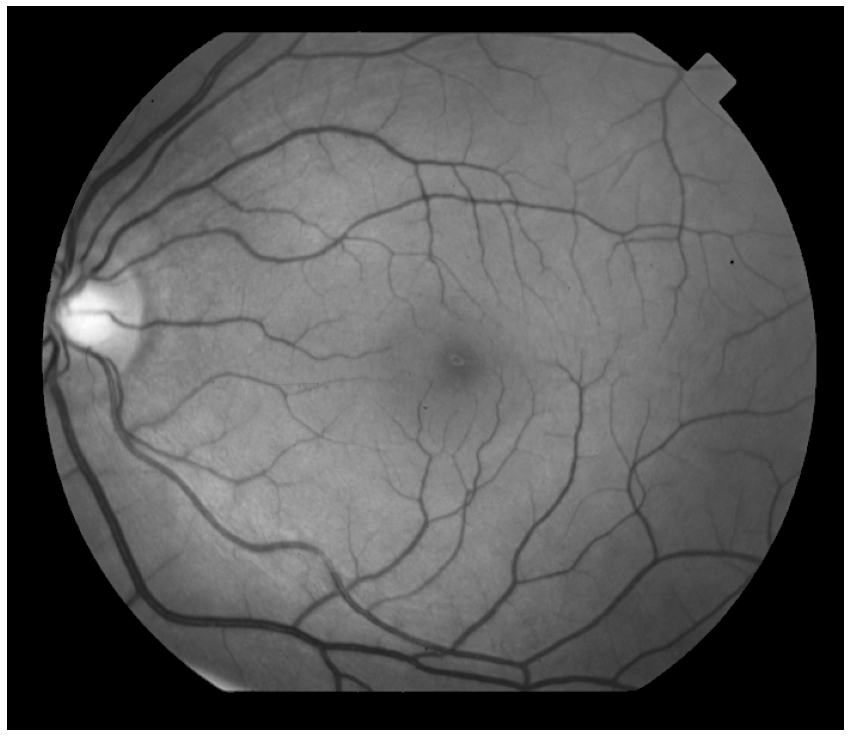

In [195]:
eye = extract_eye(img_green, img_mask).astype(np.uint16)
show_img(eye)

## Histogram equalization using CLAHE

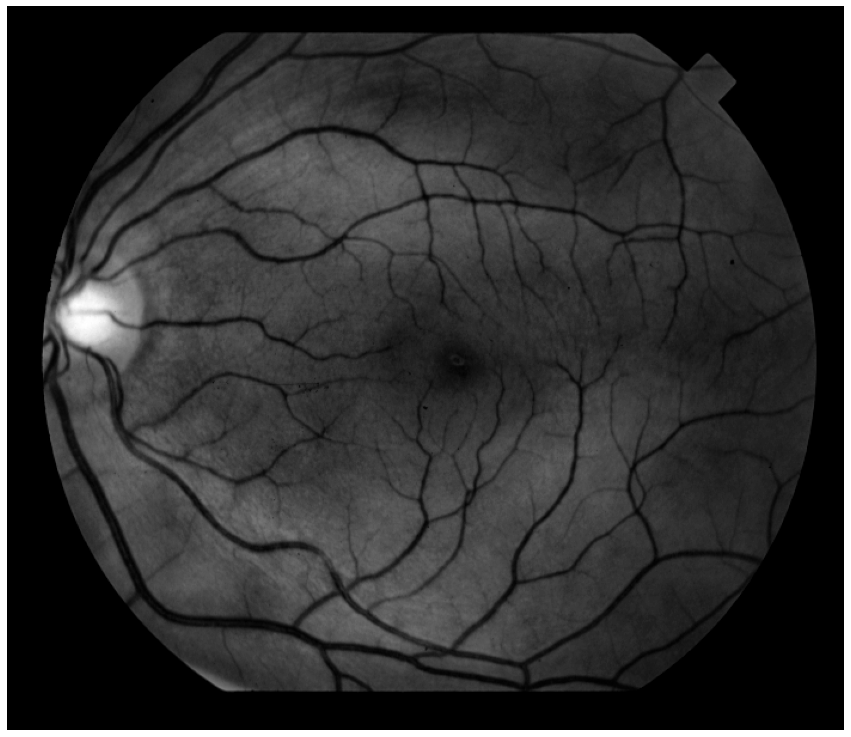

In [230]:
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(12, 12))
clache_img = clahe.apply(eye)
show_img(clache_img)
# clache_img = cv2.equalizeHist(eye.astype(np.uint8))
# show_img(clache_img)

## Normalization and Black-hat transform

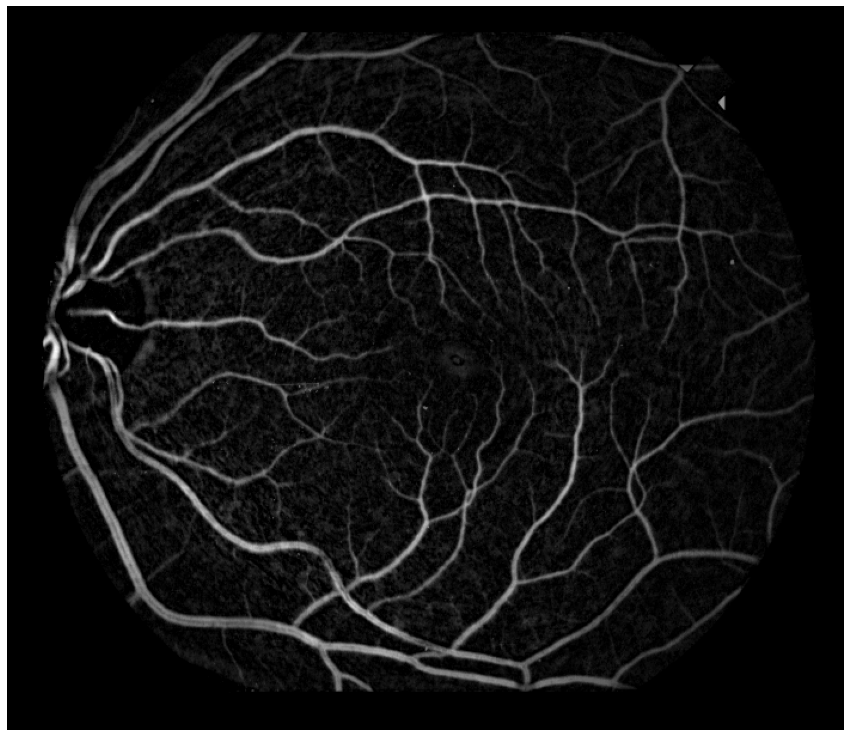

In [231]:
clache_img_norm = clache_img/clache_img.max() * 255
kernel = np.ones((13,13))
black_hat_img = cv2.morphologyEx(clache_img_norm, cv2.MORPH_BLACKHAT, kernel).astype(np.uint8)
show_img(black_hat_img)

## Thresholding

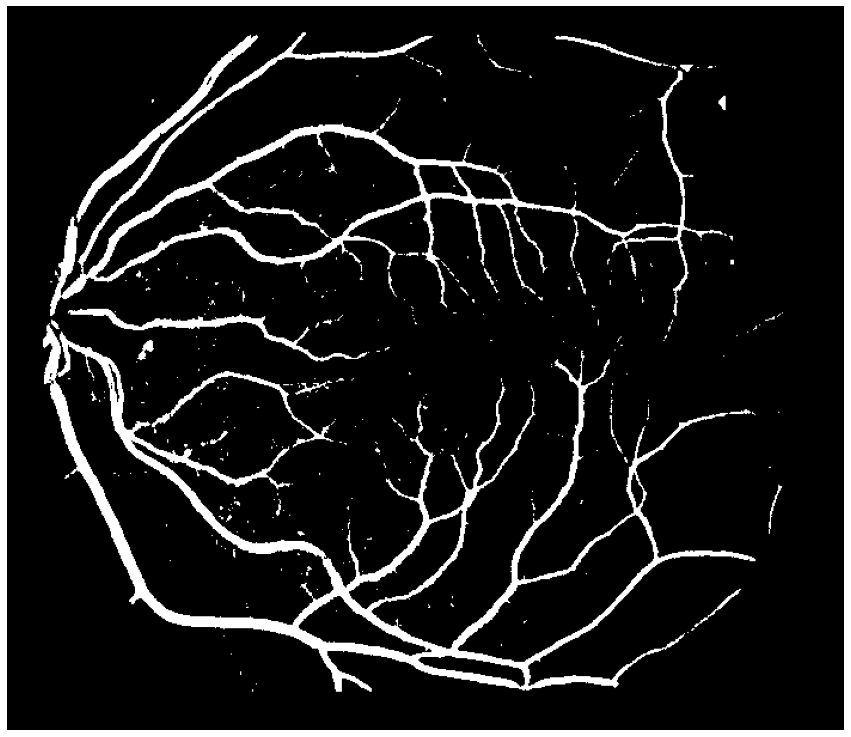

In [232]:
_, thres_img = cv2.threshold(black_hat_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show_img(thres_img)

## Dilution to connect close dots

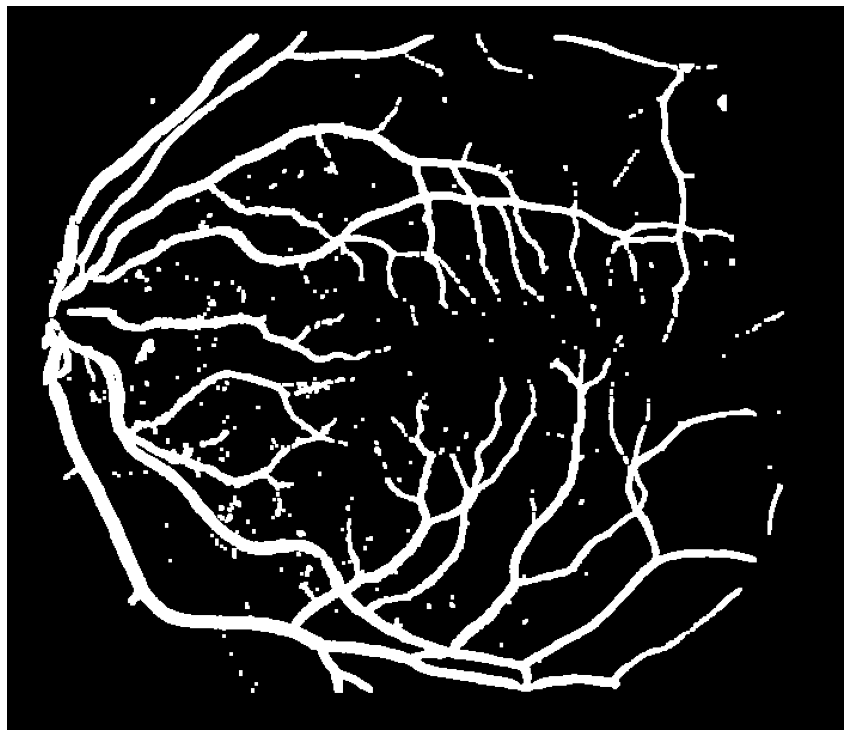

In [233]:
dil = cv2.dilate(thres_img,np.ones((3,3)),iterations=1)
show_img(dil)

## Removing small dots

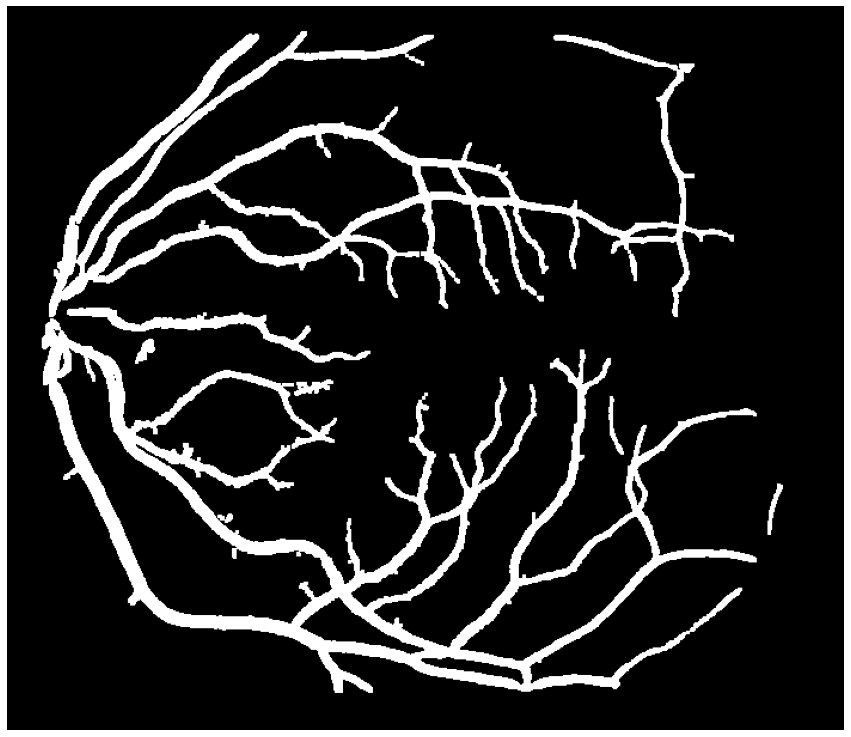

In [234]:
cleaned_img = morphology.remove_small_objects(dil.astype(bool), min_size=150, connectivity=8).astype(np.uint8) * 255
show_img(cleaned_img)

## Eroding back

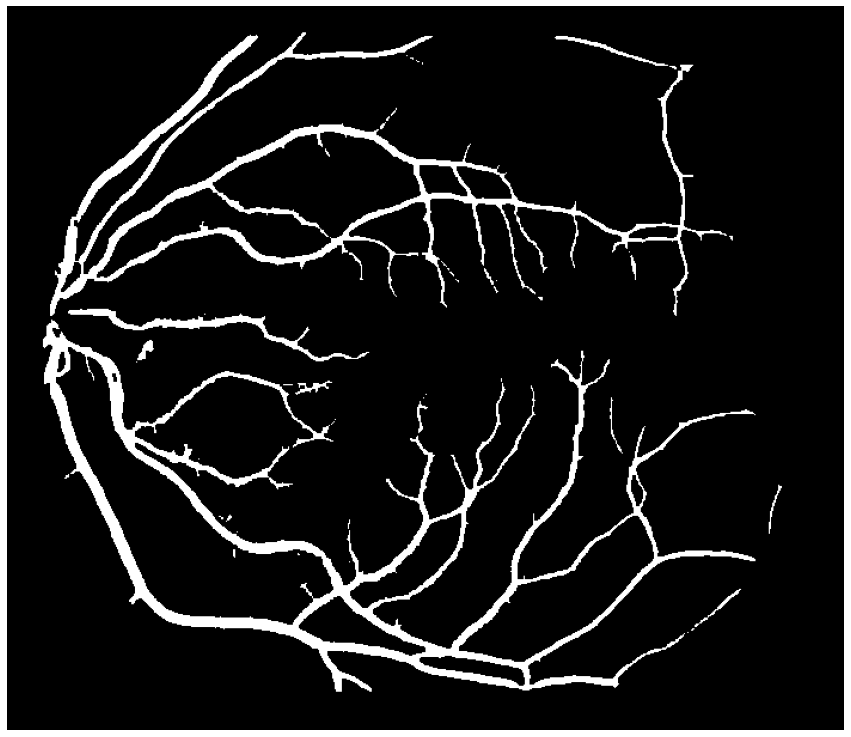

In [235]:
eroded = cv2.erode(cleaned_img,np.ones((3,3)),iterations=1)
show_img(eroded)

In [236]:
error_img, error_mat, effectiveness = error_matrix(eroded, hand_labeled, img_mask)

Accuracy 		96.19%
Sensitivity 		80.45%
Specificity 		98.14%
Precision 		84.18%


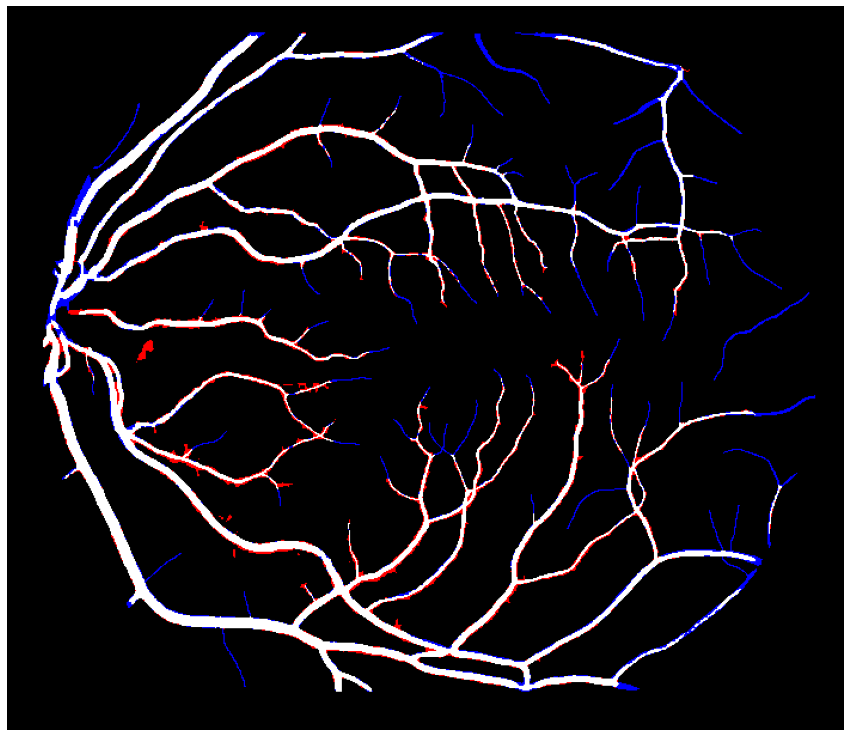

In [237]:
show_img(error_img.astype(np.uint8),True)
print('Accuracy \t\t',effectiveness['accuracy'],'%',sep='')
print('Sensitivity \t\t',effectiveness['sensitivity'],'%',sep='')
print('Specificity \t\t',effectiveness['specificity'],'%',sep='')
print('Precision \t\t',effectiveness['precision'],'%',sep='')

# 2. Classifiers

In [48]:
import skimage.measure as skimsr


In [49]:
def getHuMoments(patch):
    mom = cv2.moments(patch.astype(np.uint8))
    hu_mom = cv2.HuMoments(mom).flatten()
    return hu_mom

In [528]:
def prepareImage(img):
    c_img_green = get_green_channel(img)
    c_img_mask = get_eye_mask(img, 50)
    c_eye = extract_eye(c_img_green, c_img_mask).astype(np.uint16)
    c_clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    c_clache_img = c_clahe.apply(c_eye)
    return c_clache_img

In [51]:
# def getTrainingDataFromImage(img, hand, patch_size):
#     patches, decisions = divideIntoPatchesWithDecision(img, hand, patch_size) 
#     patch_data = []
#     for patch in patches:
#         patch_data.append(getDataFromPatch(patch))
#     return patch_data, decisions

In [52]:
# def divideIntoPatchesWithDecision(image, hand, size):
#     patches = list()
#     decisions = list()
#     half_patch = (size-1)//2
    
#     pad_width = ((half_patch,half_patch),(half_patch,half_patch))
#     image = np.pad(image, pad_width, mode='constant', constant_values=0)
    
#     for i in range(half_patch, len(image) - half_patch):
#         for j in range(half_patch, len(image[0]) - half_patch):
#             patch = image[(i-half_patch):(i+half_patch), (j-half_patch):(j+half_patch)]
#             patches.append(patch)
#             if hand[i-half_patch][j-half_patch] == 0:
#                 decisions.append(0)
#             else:
#                 decisions.append(255)
#     return patches, decisions

In [53]:
def getTrainingDataFromImage(img, hand, patch_size, samples, percent_vein):
    patches, decisions = divideIntoPatchesWithDecision(img, hand, patch_size, samples, percent_vein) 
    patch_data = []
    for patch in patches:
        patch_data.append(getDataFromPatch(patch))
    return patch_data, decisions

In [54]:
def divideIntoPatchesWithDecision(image, hand, size, samples, percent_vein):
    patches = list()
    decisions = list()
    half_patch = (size-1)//2
    
    pad_width = ((half_patch,half_patch),(half_patch,half_patch))
    image = np.pad(image, pad_width, mode='constant', constant_values=0)
    
    needed_veins = int(samples*percent_vein)
    veins_currently = 0
    samples_currently = 0
    used = []
    while samples_currently < samples:
        i = randint(half_patch, image.shape[0]-half_patch-1)
        j = randint(half_patch, image.shape[1]-half_patch-1)
        if veins_currently < needed_veins:
            if hand[i-half_patch][j-half_patch] == 0:
                continue
            if [i,j] in used:
                continue
            veins_currently += 1
            
        used.append([i,j])
        patch = getPatch(i,j,image,size)
        patches.append(patch)
        samples_currently += 1
        if hand[i-half_patch][j-half_patch] == 0:
            decisions.append(0)
        else:
            decisions.append(1)
    
#     for i in range(half_patch, len(image) - half_patch):
#         for j in range(half_patch, len(image[0]) - half_patch):
#             patch = image[(i-half_patch):(i+half_patch), (j-half_patch):(j+half_patch)]
#             patches.append(patch)
#             if hand[i-half_patch][j-half_patch] == 0:
#                 decisions.append(0)
#             else:
#                 decisions.append(255)
    return patches, decisions

In [55]:
def divideIntoPatches(image,size):
    patches = list()
    half_patch = (size-1)//2
    
    pad_width = ((half_patch,half_patch),(half_patch,half_patch))
    image = np.pad(image, pad_width, mode='constant', constant_values=0)
    
    for i in range(half_patch, len(image) - half_patch):
        for j in range(half_patch, len(image[0]) - half_patch):
            patch = image[(i-half_patch):(i+half_patch), (j-half_patch):(j+half_patch)]
            patches.append(patch)
    return patches

In [56]:
def getPatch(i, j, img, patch_size):
    half_patch = (patch_size-1)//2
    pad_width = ((half_patch,half_patch),(half_patch,half_patch))
    img = np.pad(img, pad_width, mode='constant', constant_values=0)
    return img[(i):(i+patch_size), (j):(j+patch_size)]

In [154]:
def getDataFromPatch(patch):
    hu = getHuMoments(patch)
#     M = skimsr.moments(patch)
#     centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0])
#     cen_mom = skimsr.moments_central(patch, centroid).flatten()
    colors = patch.flatten()
#     return np.concatenate((hu,colors,cen_mom))
    return np.concatenate((hu,colors))

## Preparing training and test sets

In [58]:
training_set = []
training_results = []
data = []
images = os.listdir('images')
train_size = int(0.8*len(images))
train_set = images[:train_size]
test_set = images[train_size:]

## Preparing the model

In [59]:
# def createModel(neighbours, patch_size):
#     data_attrbutes = list()
#     data_decisions = list()
#     for image in train_set:
#         train_image = imgio.imread('images/'+image)
#         train_goal = imgio.imread('hand/'+image[:-4]+'.ah'+image[-4:])
        
#         train_image = prepareImage(train_image)
        
#         image_attributes, image_decisions = getTrainingDataFromImage(train_image, train_goal, patch_size)
        
#         data_attrbutes += image_attributes
#         data_decisions += image_decisions
        
#     model = KNeighborsClassifier(n_neighbors=neighbours)
    
#     model.fit(data_attrbutes,data_decisions)
    
#     return model

In [60]:
def createModel(neighbours, patch_size, samples, percent_vein):
    data_attrbutes = list()
    data_decisions = list()
    for image in train_set:
        train_image = imgio.imread('images/'+image)
        train_goal = imgio.imread('hand/'+image[:-4]+'.ah.ppm')
        
        train_image = prepareImage(train_image)
        
        #image_attributes, image_decisions = getTrainingDataFromImage(train_image, train_goal, patch_size)
        image_attributes, image_decisions = getTrainingDataFromImage(train_image, train_goal, patch_size, samples, percent_vein)
        
        data_attrbutes += image_attributes
        data_decisions += image_decisions
        
    model = KNeighborsClassifier(n_neighbors=neighbours)
    
    model.fit(data_attrbutes,data_decisions)
    
    return model

## Preparing the image

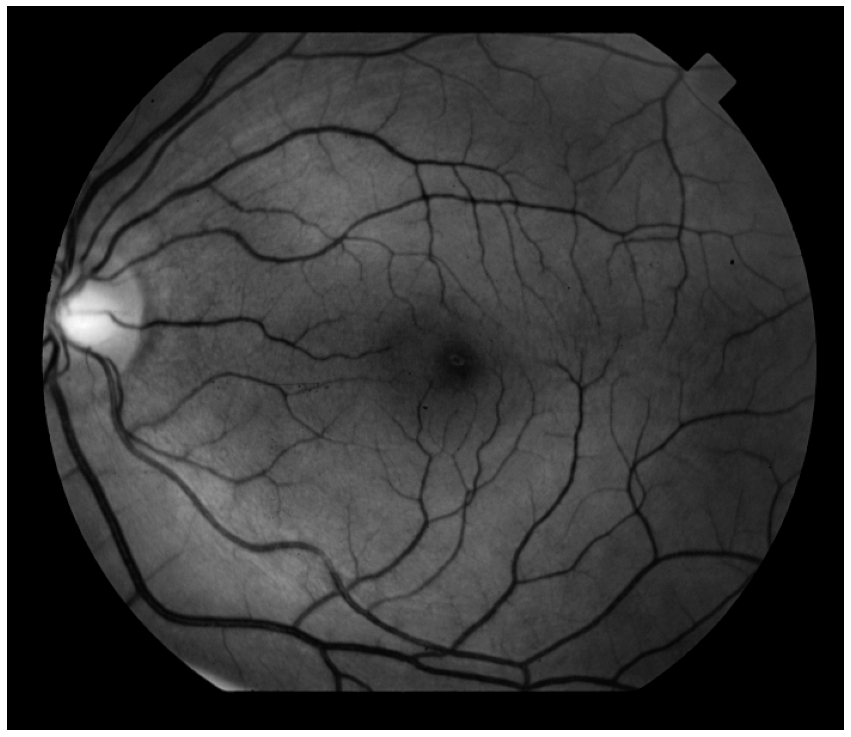

In [518]:
prepared_image = prepareImage(img)

show_img(prepared_image)

## Creating the model

In [547]:
NEIGHBORS = 5
PATCH_SIZE = 5
SAMPLES = 300
PERCENTAGE_VEINS = 0.375

In [548]:
model = createModel(NEIGHBORS, PATCH_SIZE, SAMPLES, PERCENTAGE_VEINS)

## Generating the predition

In [540]:
prediction = np.zeros((prepared_image.shape[0],prepared_image.shape[1]))
for x in range(prepared_image.shape[0]):
    for y in range(prepared_image.shape[1]):
        if img_mask[x][y] == 0:
            continue
        current_patch = getPatch(x,y,prepared_image,PATCH_SIZE)
        in_data = getDataFromPatch(current_patch)
        decision = model.predict([in_data])
        prediction[x][y] = decision[0]*255

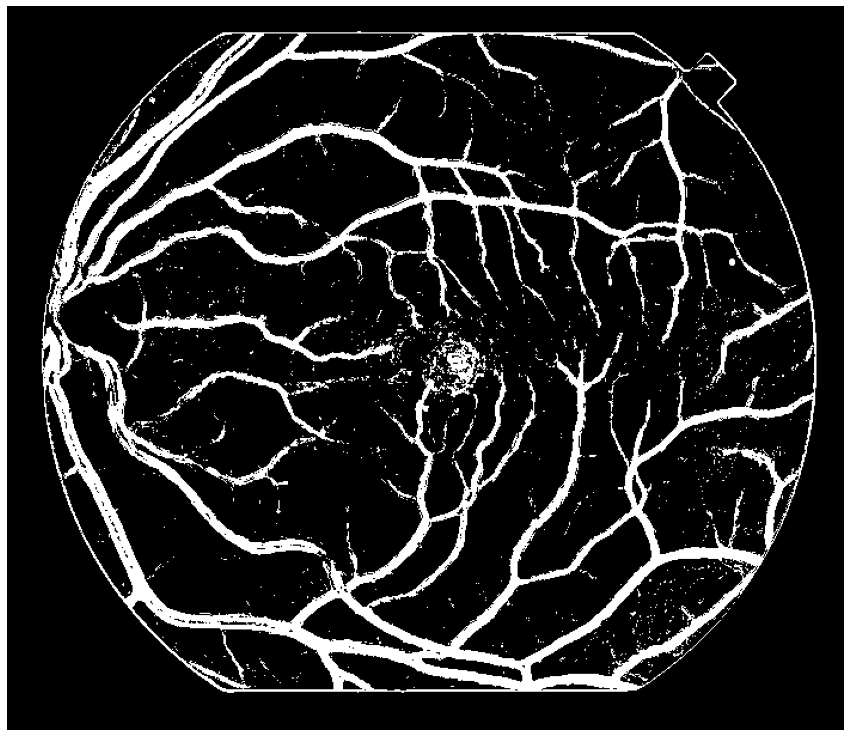

In [541]:
show_img(prediction)
# NEIGHBORS = 5
# PATCH_SIZE = 5
# SAMPLES = 300
# PERCENTAGE_VEINS = 0.4
# Accuracy          91.3%
# Sensitivity       92.09%
# Specificity       91.2%
# Precision         56.33%

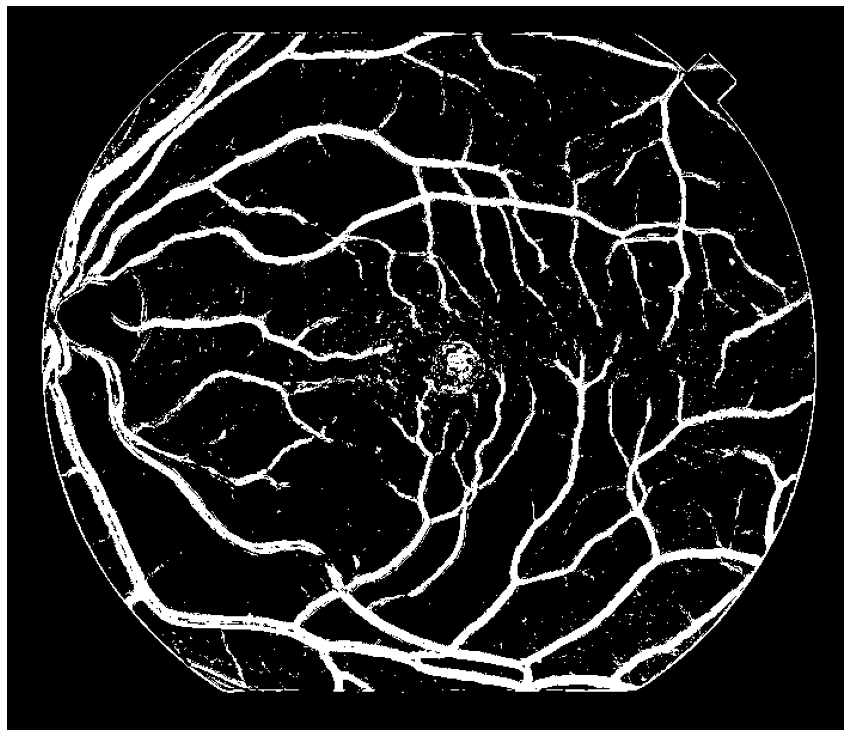

In [502]:
show_img(prediction)
# NEIGHBORS = 5
# PATCH_SIZE = 5
# SAMPLES = 300
# PERCENTAGE_VEINS = 0.375
# Accuracy          91.94%
# Sensitivity       91.48%
# Specificity       91.99%
# Precision         58.48%

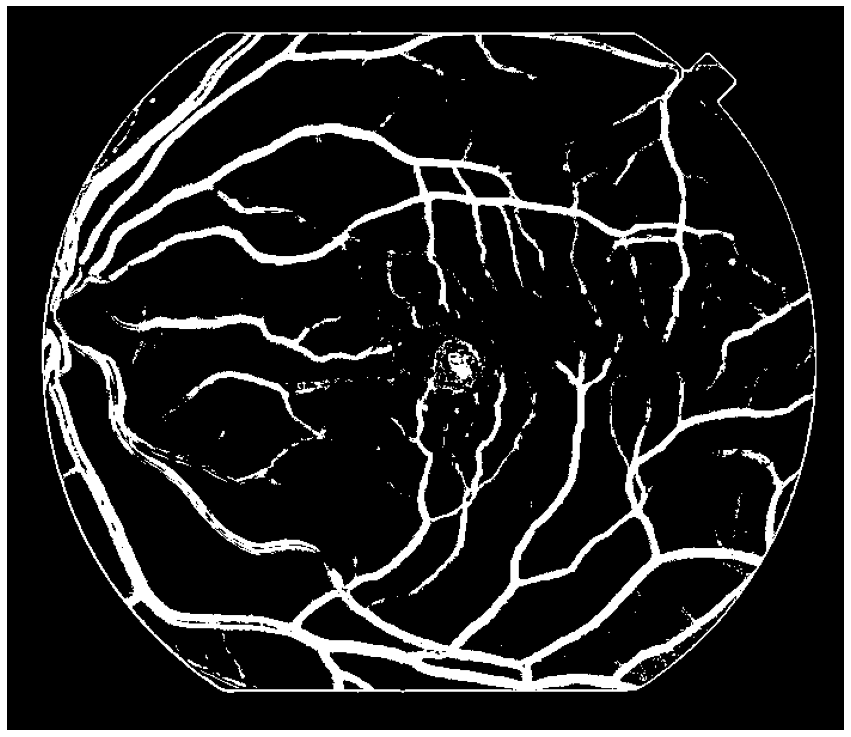

In [532]:
show_img(prediction)
# NEIGHBORS = 15
# PATCH_SIZE = 5
# SAMPLES = 300
# PERCENTAGE_VEINS = 0.375
# Accuracy          92.99%
# Sensitivity       86.15%
# Specificity       93.84%
# Precision         63.28%

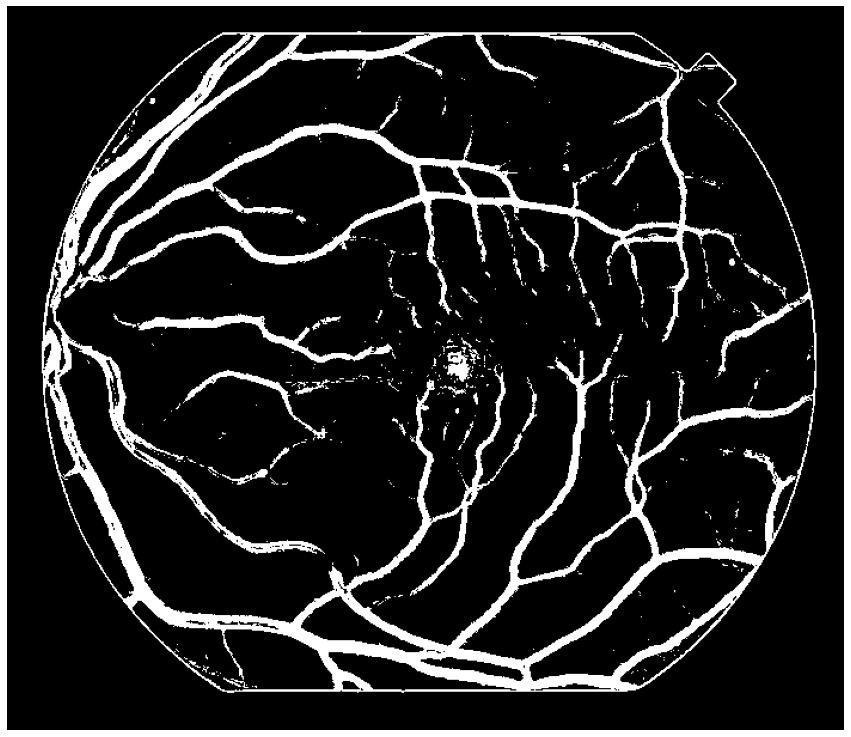

In [420]:
show_img(prediction)
# NEIGHBORS = 10
# PATCH_SIZE = 5
# SAMPLES = 300
# PERCENTAGE_VEINS = 0.375
# Accuracy          93.39%
# Sensitivity       86.84%
# Specificity       94.2%
# Precision         64.87%

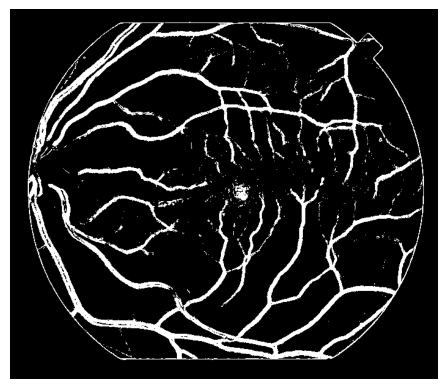

In [103]:
show_img(prediction) #tylko hu i color 10 5 200 0.375

## Post-processing

#### Removing contours

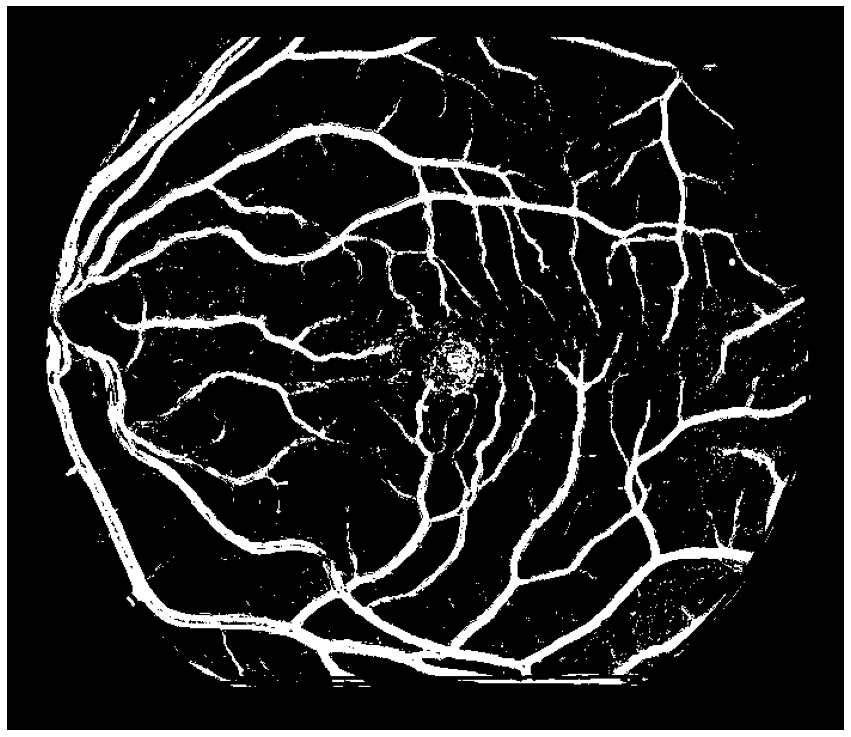

In [551]:
img_no_contours = remove_contours(prediction, img_mask, 3)
show_img(img_no_contours)

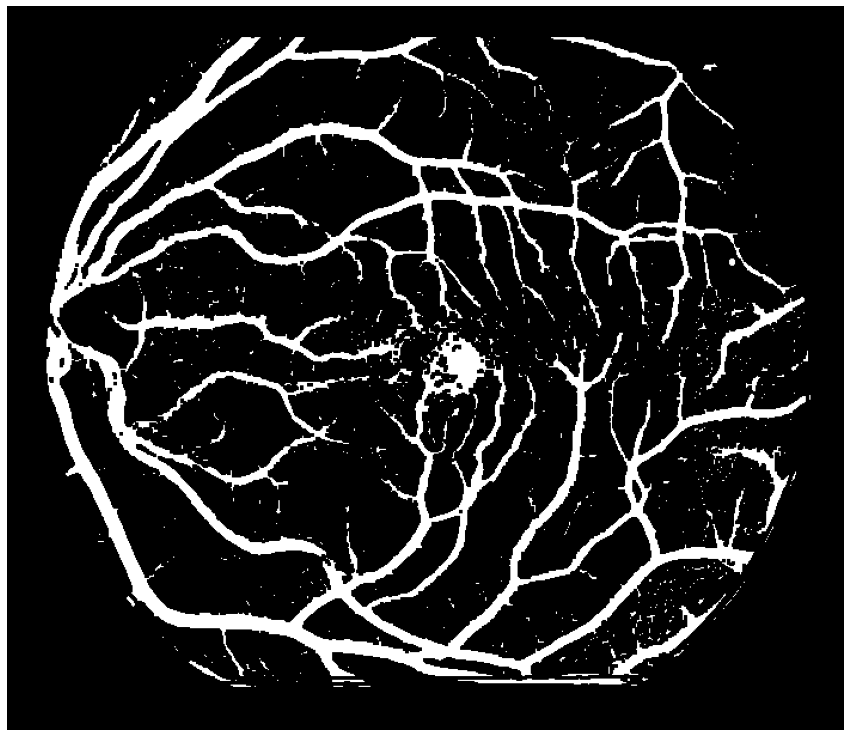

In [552]:
#c_dil = cv2.dilate(img_no_contours,np.ones((3,3)),iterations=1)
c_dil = cv2.morphologyEx(img_no_contours,cv2.MORPH_CLOSE,np.ones((3,3)))
show_img(c_dil)

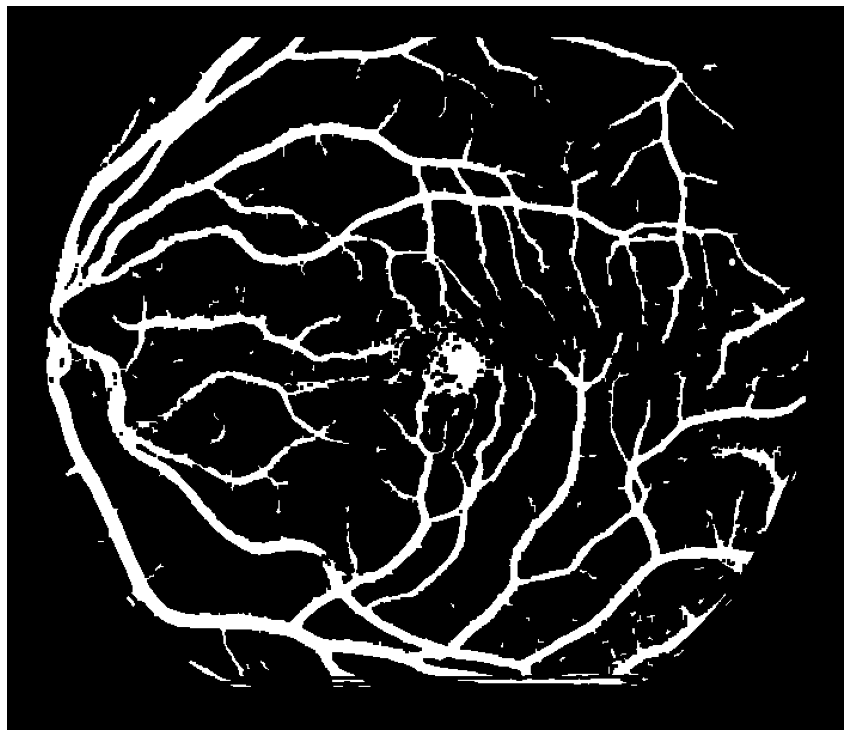

In [553]:
c_cleaned_img = morphology.remove_small_objects(c_dil.astype(bool), min_size=5, connectivity=8).astype(np.uint8)
show_img(c_cleaned_img)

In [554]:
c_error_img, c_error_mat, c_effectiveness = error_matrix(c_cleaned_img, hand_labeled, img_mask)

Accuracy 		91.3%
Sensitivity 		89.69%
Specificity 		91.5%
Precision 		56.55%


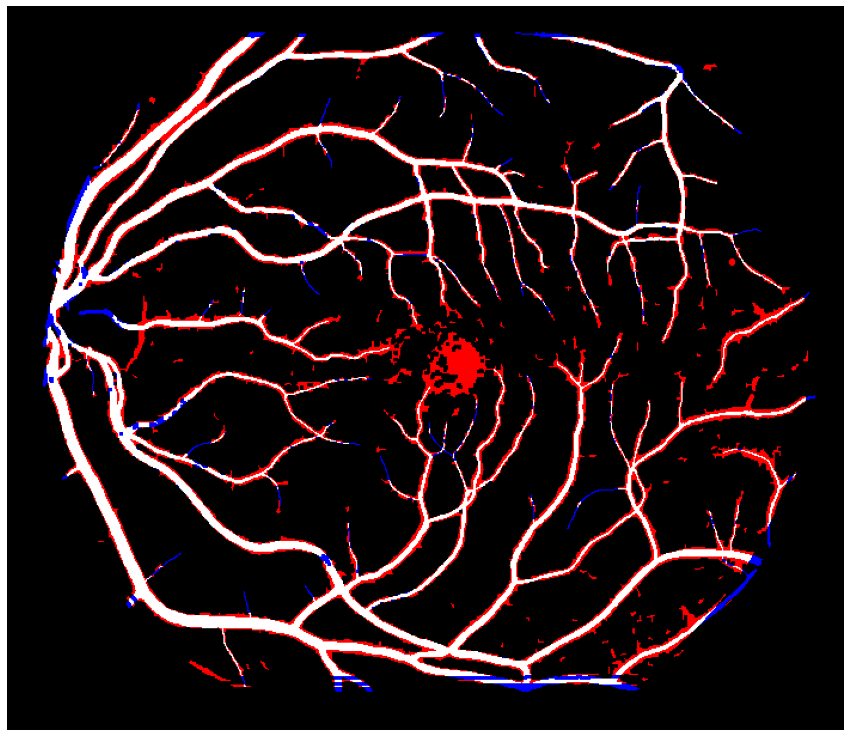

In [555]:
show_img(c_error_img.astype(np.uint8),True)
print('Accuracy \t\t',c_effectiveness['accuracy'],'%',sep='')
print('Sensitivity \t\t',c_effectiveness['sensitivity'],'%',sep='')
print('Specificity \t\t',c_effectiveness['specificity'],'%',sep='')
print('Precision \t\t',c_effectiveness['precision'],'%',sep='')

Accuracy 		90.78%
Sensitivity 		89.56%
Specificity 		90.95%
Precision 		58.06%
Accuracy 		93.66%
Sensitivity 		70.68%
Specificity 		95.37%
Precision 		53.2%
Accuracy 		94.22%
Sensitivity 		51.83%
Specificity 		96.87%
Precision 		50.9%
Accuracy 		92.53%
Sensitivity 		50.74%
Specificity 		96.71%
Precision 		60.7%


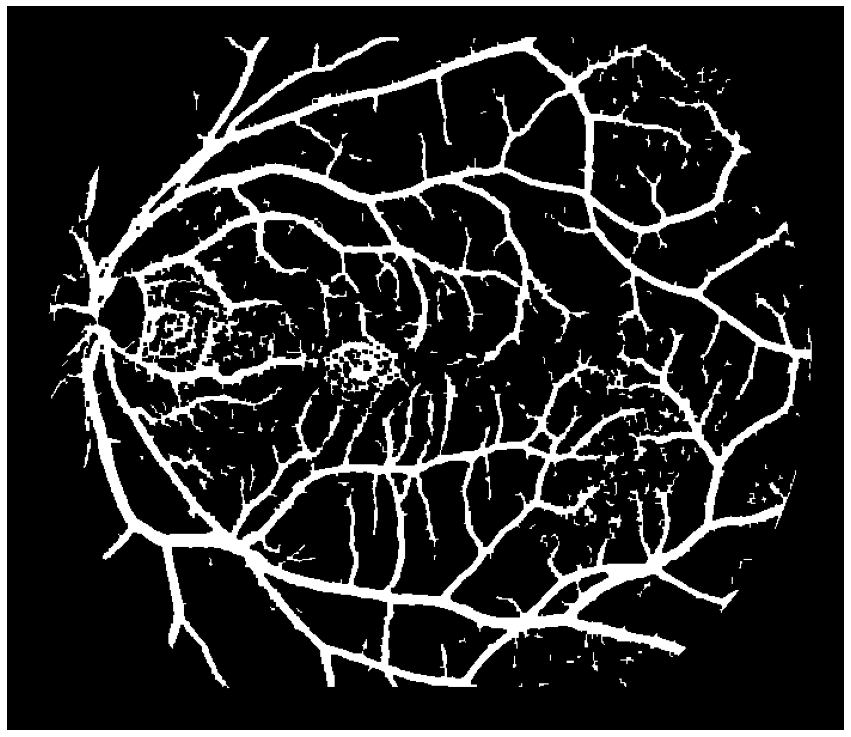

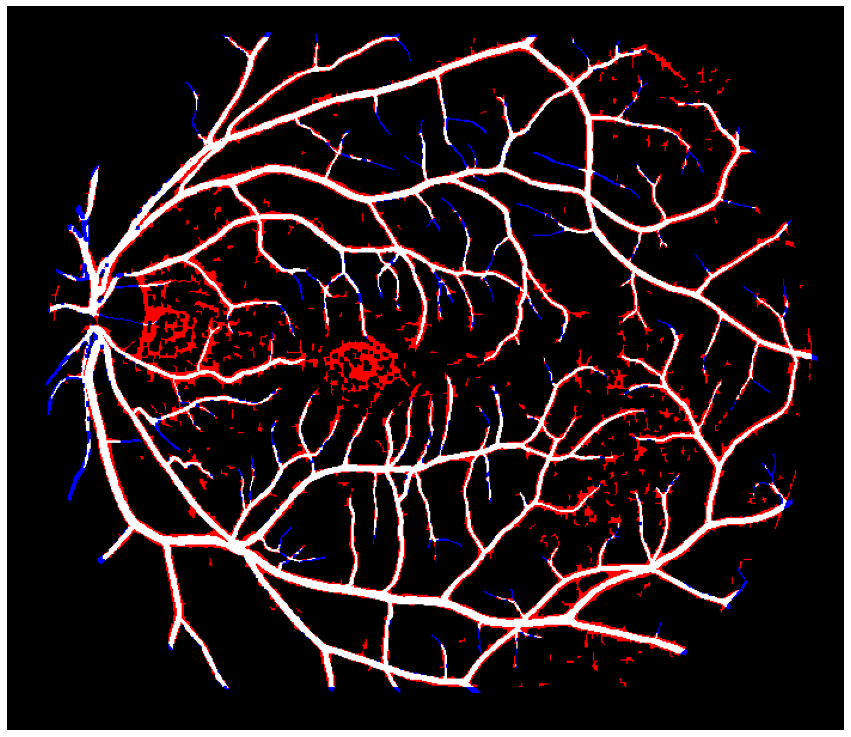

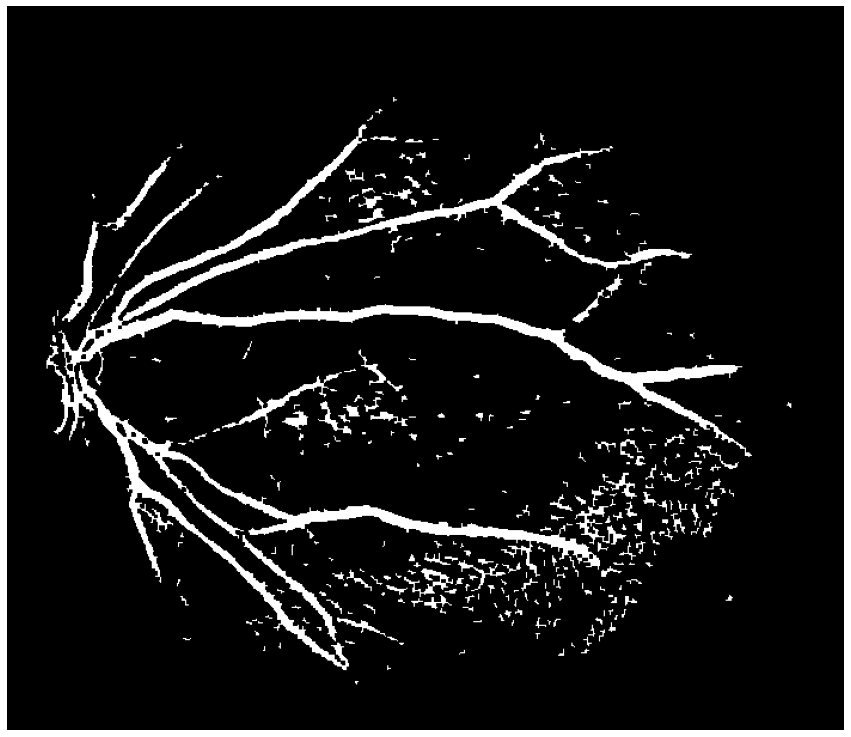

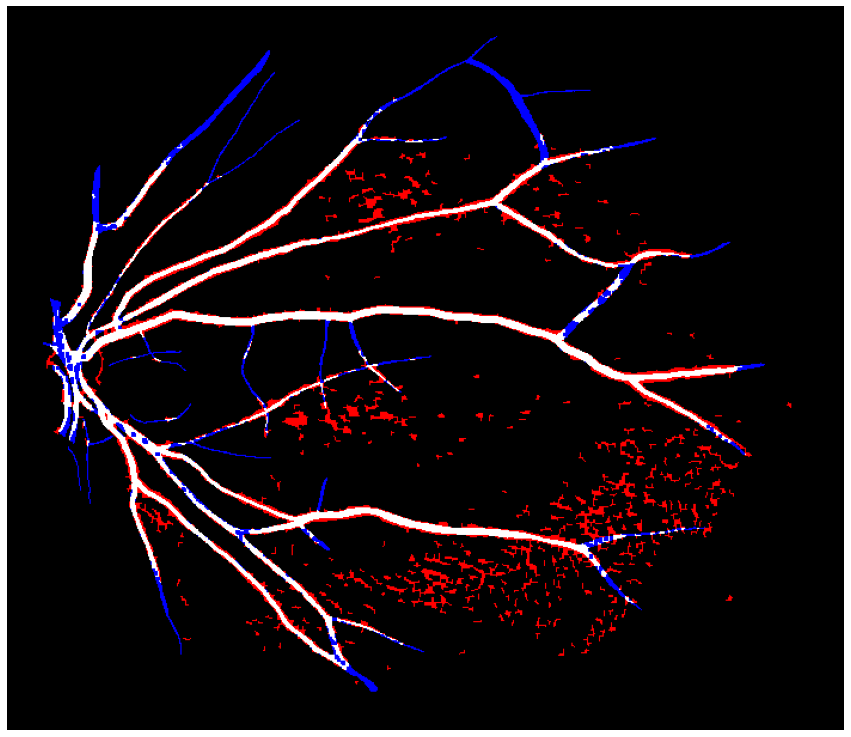

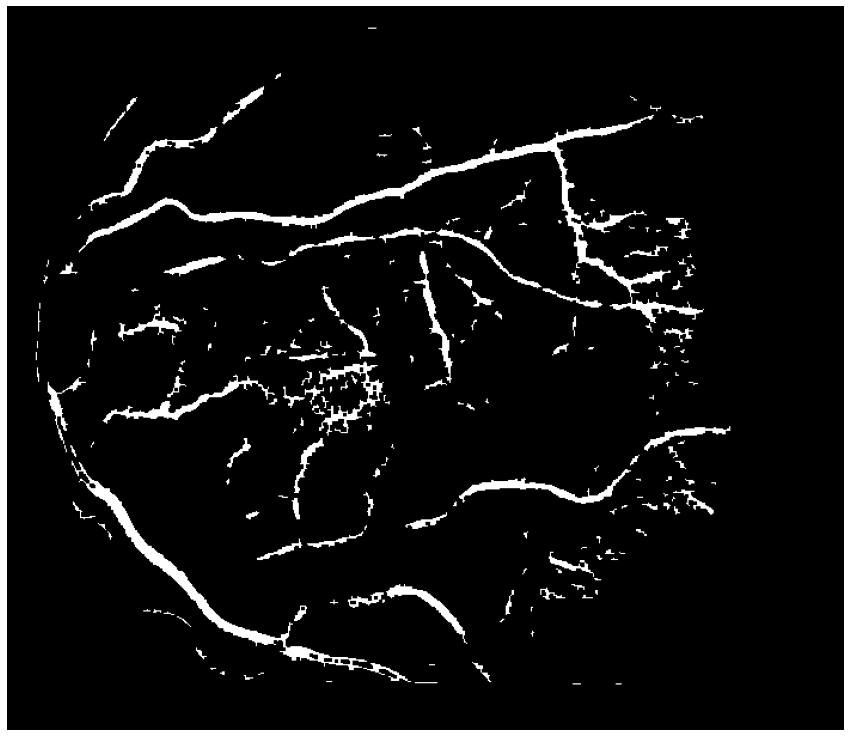

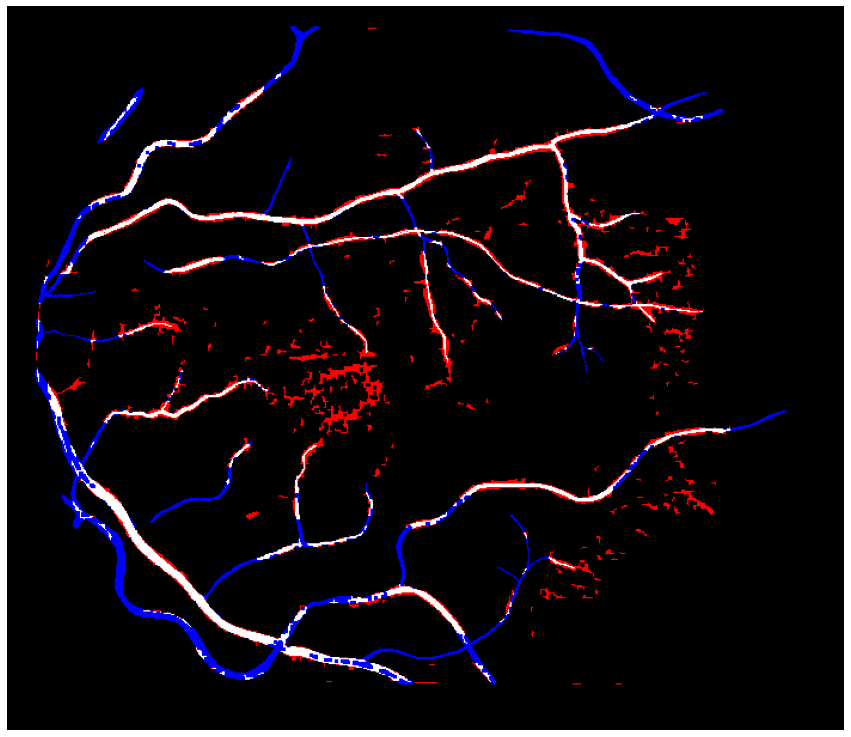

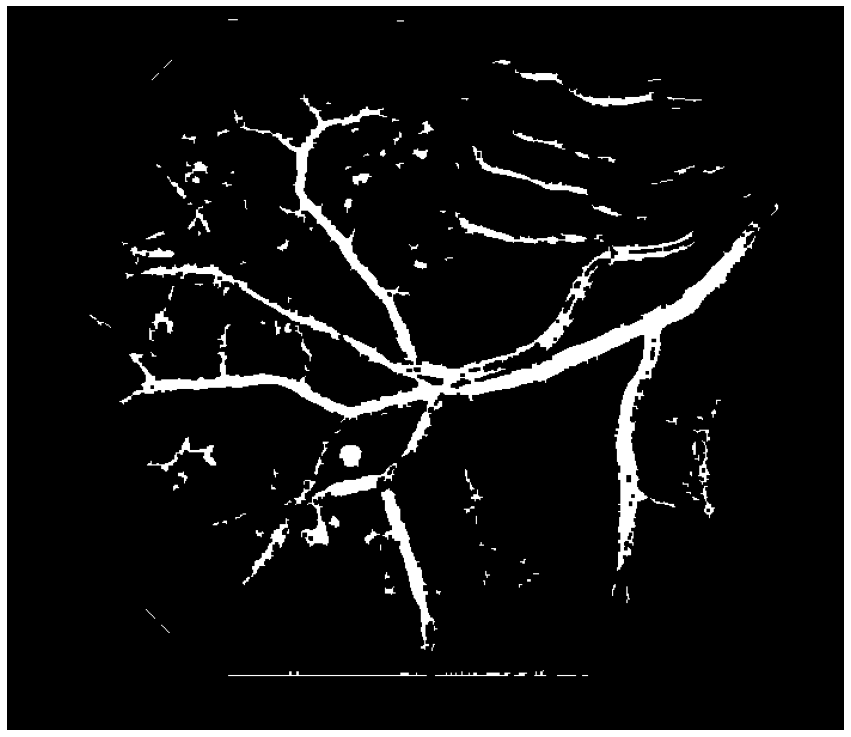

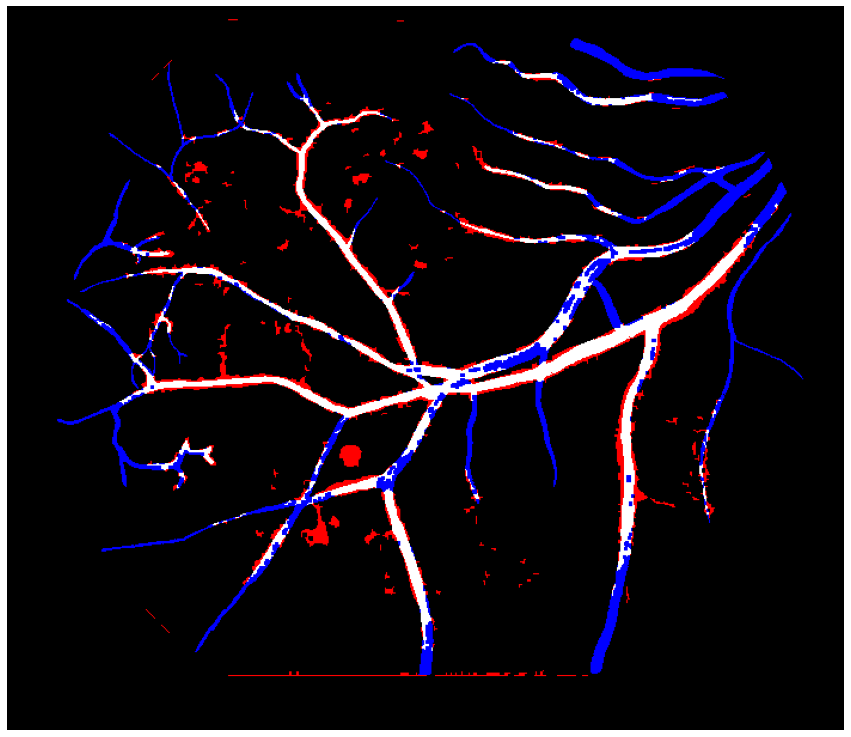

In [550]:
for image in test_set:
    test_image = imgio.imread('images/'+image)
    test_goal = imgio.imread('hand/'+image[:-4]+'.ah.ppm')
    test_img_mask = get_eye_mask(test_image, 50)
    test_image = prepareImage(test_image)
    test_prediction = np.zeros((test_image.shape[0],test_image.shape[1]))
    for x in range(test_image.shape[0]):
        for y in range(test_image.shape[1]):
            if test_img_mask[x][y] == 0:
                continue
            current_patch = getPatch(x,y,test_image,PATCH_SIZE)
            in_data = getDataFromPatch(current_patch)
            decision = model.predict([in_data])
            test_prediction[x][y] = decision[0]*255
    test_img_no_contours = remove_contours(test_prediction, test_img_mask, 2)
    test_c_dil = cv2.morphologyEx(test_img_no_contours,cv2.MORPH_CLOSE,np.ones((3,3)))
    test_c_cleaned_img = morphology.remove_small_objects(test_c_dil.astype(bool), min_size=5, connectivity=8).astype(np.uint8)
    show_img(test_c_cleaned_img)
    test_c_error_img, test_c_error_mat, test_c_effectiveness = error_matrix(test_c_cleaned_img, test_goal, test_img_mask)
    show_img(test_c_error_img.astype(np.uint8),True)
    print('Accuracy \t\t',test_c_effectiveness['accuracy'],'%',sep='')
    print('Sensitivity \t\t',test_c_effectiveness['sensitivity'],'%',sep='')
    print('Specificity \t\t',test_c_effectiveness['specificity'],'%',sep='')
    print('Precision \t\t',test_c_effectiveness['precision'],'%',sep='')